# BERT

In [27]:
local = True
log = True
log_detail = False

## Imports

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from sklearn.preprocessing import LabelEncoder

import os
import sys
sys.path.append(os.path.abspath('..'))
import pickle

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [30]:
if local:
    misconceptions = pd.read_csv('../kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv', index_col='MisconceptionId')
    train = pd.read_csv('../kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv')
    test = pd.read_csv('../kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv')
else:
    misconceptions = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv', index_col='MisconceptionId')
    train = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv')
    test = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv')
if log: print("(1) Imported data")

(1) Imported data


## Clean data

In [31]:
# Define the identifier columns
id_cols = [
    'QuestionId', 'ConstructId', 'ConstructName', 
    'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText'
]

# Define the corresponding Answer options
answer_cols = ['AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']
misconception_cols = ['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']

# Melt Answer Text
text_melted = train.melt(
    id_vars=id_cols,
    value_vars=answer_cols,
    var_name='Attribute',
    value_name='AnswerText'
)

# Melt Misconception IDs
misconception_melted = train.melt(
    id_vars=id_cols,
    value_vars=misconception_cols,
    var_name='Attribute',
    value_name='MisconceptionId'
)

# Extract the option letter (A, B, C, D) and the attribute type
text_melted['AnswerOption'] = text_melted['Attribute'].str.extract(r'Answer([ABCD])Text')[0]
misconception_melted['AnswerOption'] = misconception_melted['Attribute'].str.extract(r'Misconception([ABCD])Id')[0]

# Drop the original 'Attribute' columns as they are no longer needed
text_melted.drop('Attribute', axis=1, inplace=True)
misconception_melted.drop('Attribute', axis=1, inplace=True)

# Merge the two melted DataFrames on id_vars and AnswerOption
train_melted = pd.merge(
    text_melted,
    misconception_melted,
    on=id_cols + ['AnswerOption'],
    how='left'
)

train_melted = train_melted.merge(misconceptions, left_on='MisconceptionId', right_index=True, how='left')
if log: print("(2) Created train_melted")

(2) Created train_melted


In [32]:
misconception_list = list(misconceptions['MisconceptionName'])

In [33]:
if log_detail: print("Shape before:", train_melted.shape)

# Remove rows with missing MisconceptionName, remove misconceptinos that only appear once
train_melted = train_melted.dropna(subset=['MisconceptionName'])
train_melted = train_melted.groupby('MisconceptionId').filter(lambda x: len(x) > 1)

if log_detail: print("Shape after:", train_melted.shape)
if log: print("(3) Shaped train_melted to", train_melted.shape)

(3) Shaped train_melted to (3623, 11)


## Tokenize

In [34]:
# Split into training and validation sets

train, valid = train_test_split(train_melted, test_size=0.25, random_state=123, stratify=train_melted['MisconceptionName'])

In [35]:
from transformers import BertTokenizer

if local: 
    bert_path = 'bert-base-uncased'
else:
    bert_path = '/kaggle/input/google-bertbert-base-uncased/transformers/default/1/cache/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594'

tokenizer = BertTokenizer.from_pretrained(bert_path)

def tokenize_data(question, answer, max_length=256):
    return tokenizer.encode_plus(
        question,
        answer,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation='only_first',
        return_attention_mask=True,
        return_tensors='pt'
    )

In [36]:
# Example tokenization
if local:
    tokenized_sample = tokenize_data(train['QuestionText'].iloc[0], train['AnswerText'].iloc[0])
    print(tokenized_sample)

{'input_ids': tensor([[ 101, 2054, 2003, 1996, 2675, 7117, 1997, 7032, 1029,  102, 1032, 1006,
         3590, 1032, 1007,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,

In [37]:
import torch
from torch import nn
from transformers import BertModel

class BERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTClassifier, self).__init__()
        if local:
            self.bert = BertModel.from_pretrained('bert-base-uncased')
        else:
            self.bert = BertModel.from_pretrained('/kaggle/input/google-bertbert-base-uncased/transformers/default/1/cache/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594')
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = outputs[1]  # [CLS] token
        output = self.dropout(pooled_output)
        return self.out(output)

# Dataset

In [38]:
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train['MisconceptionName'])
val_labels = le.transform(valid['MisconceptionName'])
n_classes = len(le.classes_)

# if local:
#     with open('label_encoder.pkl', 'wb') as f:
#         pickle.dump(le, f)

In [39]:
# Define custom dataset, which tokenizes question and answer together
# If the token length is greater than max_len, truncate the question (never the answer)

class MisconceptionDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len=256):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = str(self.questions[idx])
        answer = str(self.answers[idx])
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation='only_first',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


# Create datasets and dataloaders

train_dataset = MisconceptionDataset(
    questions=train['QuestionText'].to_numpy(),
    answers=train['AnswerText'].to_numpy(),
    labels=train_labels,
    tokenizer=tokenizer
)

val_dataset = MisconceptionDataset(
    questions=valid['QuestionText'].to_numpy(),
    answers=valid['AnswerText'].to_numpy(),
    labels=val_labels,
    tokenizer=tokenizer
)

if local:
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)

if log: print("(4) Created DataLoaders")

(4) Created DataLoaders


In [40]:
train.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerText,AnswerOption,MisconceptionId,MisconceptionName
2948,1079,479,Calculate the square root of a number,246,"Square Roots, Cube Roots, etc",D,What is the square root of sixteen?,\( 32 \),B,2017.0,Mixes up square rooting and multiplying by 2 or doubling
3900,162,2760,Calculate the median as an average from an even numbered list of data,102,"Averages (mean, median, mode) from a List of Data",A,"What is the median of the following numbers?\n\[\n3,5,6,18,18,-4\n\]",\( 6 \),C,2426.0,When finding the median from a even dataset does not understand we must find the midpoint of the two values in the middle
2379,510,1961,Identify questions involving a 2D right-angled triangle that require the use of the Tangent (tan) ratio,279,Right-angled Triangles (SOHCAHTOA),C,"Which ratio would you use to find the value of \( p \) ? ![A right-angled triangle with the angle labelled 32 degrees, the side adjacent to this is 6cm and the side opposite is p.]()",Cos,B,809.0,Uses cos when tan is required
6256,649,311,Multiply a decimal by an integer,224,Multiplying and Dividing with Decimals,B,Tom and Katie are discussing multiplying decimals.\n\nTom says \( 5 \times 3.9=3 \times 5.9 \)\n\nKatie says \( 5 \times 3.9=3.9 \times 5 \)\n\nWho is correct?,Neither is correct,D,638.0,Believes multiplication is not commutative
912,912,100,Recognise and use efficient strategies for mental subtraction,203,Mental Addition and Subtraction,B,Nick wants to subtract \( 199 \) from a number.\nWhich one of the following methods would give him the correct answer?,\( +200 \) then \( +1 \),A,1338.0,Does not understand the effect of consecutive operations


(A) Calculating token lengths for each question-answer pair...
(B) Token lengths calculated.


/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_96474/2267279171.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


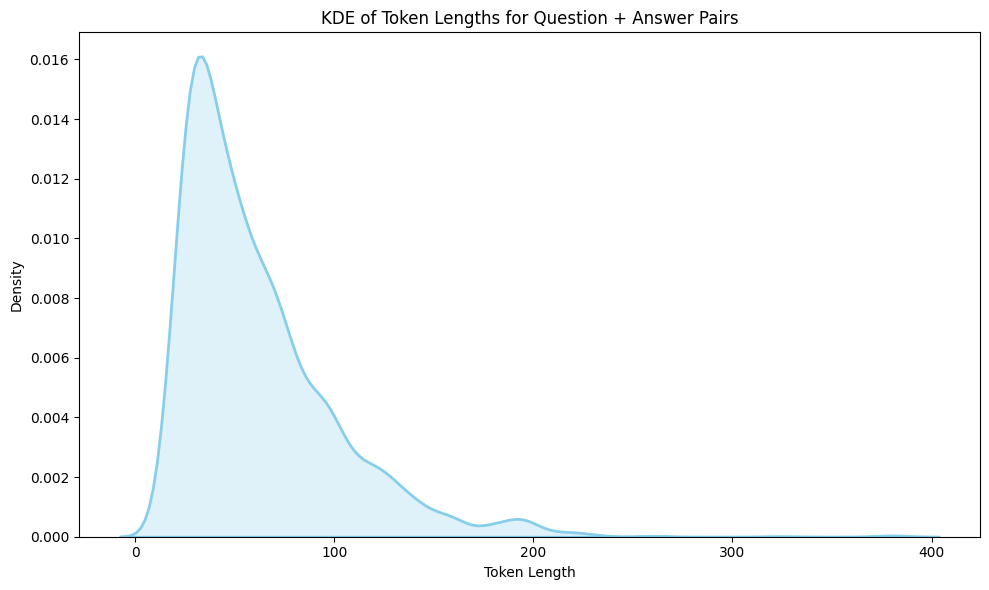

In [41]:
def get_token_length(question, answer, tokenizer):
    tokens = tokenizer.encode(question, answer, add_special_tokens=True)
    return len(tokens)

# Apply the function to compute token lengths
print("(A) Calculating token lengths for each question-answer pair...")
train_melted['TokenLength'] = train_melted.apply(
    lambda x: get_token_length(x['QuestionText'], x['AnswerText'], tokenizer), axis=1
)
print("(B) Token lengths calculated.")

# Plotting the KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=train_melted,
    x='TokenLength',
    shade=True,
    color='skyblue',
    linewidth=2
)
plt.title('KDE of Token Lengths for Question + Answer Pairs')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

## Train model

In [42]:
def calculate_map25(predictions, labels, k=25):
    """
    Calculate MAP@25 for a batch of predictions
    predictions: tensor of shape (batch_size, num_classes) with model outputs
    labels: tensor of shape (batch_size) with true labels
    """
    batch_size = predictions.size(0)
    if batch_size == 0:
        return 0.0
    
    # Get top k predictions
    _, pred_indices = predictions.topk(k)
    pred_indices = pred_indices.cpu().numpy()
    labels = labels.cpu().numpy()
    
    # Calculate AP for each sample
    aps = []
    for i in range(batch_size):
        ap = 0
        hits = 0
        for j in range(min(k, len(pred_indices[i]))):
            if pred_indices[i][j] == labels[i]:
                hits += 1
                ap += hits / (j + 1)
                break  # Since there's only one correct label per observation
        aps.append(ap)
    
    return np.mean(aps)

In [43]:
if local: 
    model_path = '../models/bert-30-20241203.pkl'
    if log: print("(5) Loading model")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if log: print("(6) Finished loading model")
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

else:
    # Initialize the model
    model = BERTClassifier(n_classes=n_classes)
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    from tqdm import tqdm
    def train_epoch(model, data_loader, optimizer, criterion, device):
        model = model.train()
        losses = []
        correct_predictions = 0

        for batch in tqdm(data_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

    # Validation loop

    def eval_model(model, data_loader, criterion, device):
        model = model.eval()
        losses = []
        correct_predictions = 0
        map_scores = []

        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs, dim=1)
                loss = criterion(outputs, labels)

                # Calculate standard metrics
                correct_predictions += torch.sum(preds == labels)
                losses.append(loss.item())
                
                # Calculate MAP@25
                map_score = calculate_map25(outputs, labels)
                map_scores.append(map_score)

        accuracy = correct_predictions.double() / len(data_loader.dataset)
        avg_loss = np.mean(losses)
        avg_map = np.mean(map_scores)

        return accuracy, avg_loss, avg_map
    
    if log: print("(5) Begin training")
    EPOCHS = 3
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Training loop
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

        val_acc, val_loss, val_map = eval_model(model, val_loader, criterion, device)
        print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f} MAP@25 {val_map:.4f}')
        print('-' * 10)
    
    if log: print("(6) Finish training")

(5) Begin training
Epoch 1/3


Training:  12%|█▏        | 5/43 [02:37<19:54, 31.42s/it]


KeyboardInterrupt: 

In [26]:
# model_filename = f"../models/model-{EPOCHS}-20241203.pkl"
# with open(model_filename, 'wb') as f:
#     pickle.dump(model, f)

NameError: name 'EPOCHS' is not defined

In [108]:
test.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText
0,1869,856,Use the order of operations to carry out calculations involving powers,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,1870,1612,Simplify an algebraic fraction by factorising the numerator,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify
2,1871,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,"Tom and Katie are discussing the \( 5 \) plants with these heights:\n\( 24 \mathrm{~cm}, 17 \mathrm{~cm}, 42 \mathrm{~cm}, 26 \mathrm{~cm}, 13 \mathrm{~cm} \)\nTom says if all the plants were cut in half, the range wouldn't change.\nKatie says if all the plants grew by \( 3 \mathrm{~cm} \) each, the range wouldn't change.\nWho do you agree with?",Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct


## Predict

In [109]:
if log: print("(7) Melt test set")
    
# Create a dictionary to map MisconceptionName to MisconceptionId
name_to_id = misconceptions.reset_index().set_index('MisconceptionName')['MisconceptionId'].to_dict()

# Reshape the test DataFrame to have one row per QuestionId_Answer (A, B, C, D)

# Include 'QuestionText' in id_vars to preserve it in the melted DataFrame
test_melted = test.melt(
    id_vars=['QuestionId', 'QuestionText', 'CorrectAnswer'],
    value_vars=['AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText'],
    var_name='AnswerOption',
    value_name='AnswerText'
)

# Clean the 'AnswerOption' column to obtain A, B, C, D
test_melted['AnswerOption'] = test_melted['AnswerOption'].str.replace('Answer', '').str.replace('Text', '')

test_melted['QA_Id'] = test_melted['QuestionId'].astype(str) + '_' + test_melted['AnswerOption']

# Drop correct answers
test_melted = test_melted[test_melted['CorrectAnswer'] != test_melted['AnswerOption']]

test_melted.head()


(7) Melt test set


,QuestionId,QuestionText,CorrectAnswer,AnswerOption,AnswerText,QA_Id
1,1870,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",D,A,\( m+1 \),1870_A
2,1871,"Tom and Katie are discussing the \( 5 \) plants with these heights:\n\( 24 \mathrm{~cm}, 17 \mathrm{~cm}, 42 \mathrm{~cm}, 26 \mathrm{~cm}, 13 \mathrm{~cm} \)\nTom says if all the plants were cut in half, the range wouldn't change.\nKatie says if all the plants grew by \( 3 \mathrm{~cm} \) each, the range wouldn't change.\nWho do you agree with?",B,A,Only\nTom,1871_A
3,1869,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,A,B,\( 3 \times 2+(4-5) \),1869_B
4,1870,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",D,B,\( m+2 \),1870_B
6,1869,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,A,C,\( 3 \times(2+4-5) \),1869_C


In [110]:
test_dataset = MisconceptionDataset(
    questions=test_melted['QuestionText'].to_numpy(),
    answers=test_melted['AnswerText'].to_numpy(),
    labels=[0]*len(test_melted), 
    tokenizer=tokenizer
)
test_loader = DataLoader(test_dataset, batch_size=16)

if log: print("(8) Making predictions")

# Make predictions
model = model.eval()
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=1)
        # Get top 25 predictions
        topk = probs.topk(25, dim=1)
        preds = topk.indices.cpu().numpy()
        predictions.extend(preds)

# Decode predictions

# Inverse transform to get MisconceptionName from class indices
predicted_misconceptions = [le.inverse_transform(pred) for pred in predictions]

# Map MisconceptionName to MisconceptionId using the name_to_id dictionary
predicted_misconception_ids = [
    ' '.join(str(name_to_id.get(name, 0)) for name in preds) for preds in predicted_misconceptions
]


if log: print("(9) Creating submission file")

# Create submission DataFrame
submission = pd.DataFrame({
    'QuestionId_Answer': test_melted['QA_Id'],
    'MisconceptionId': predicted_misconception_ids
})

# Ensure that each 'MisconceptionId' has up to 25 MisconceptionIds
submission['MisconceptionId'] = submission['MisconceptionId'].apply(lambda x: ' '.join(x.split()[:25]))

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

(8) Making predictions


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

(9) Creating submission file
Submission file created successfully.
